To see how the initial simulation was run and the initial RDF calcaulted see /Setup/Na-Na_Setup.ipynb

## Importing Libraries

In [21]:
import MagicTools as mt

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import os

import string

import itertools as it

from scipy.signal import savgol_filter

import random
random.seed(1)

## Running the LAMMPS simulations

It is necessary to run a large number of LAMMPS simulations to generate the training data for the network

In [2]:
input_rdf = mt.ReadRDF('Setup/NaNa.rdf', quiet= True)

Min = 0  
Max = input_rdf.DFs[0].Max #range of r for potentials

In [3]:
forbid = input_rdf.DFs[0].x[0] #this is the starting point for any potential, below this potential should be large
#this should be altered so that if the RDF contains very low values at the start (say <= 0.1), these likely still are
#part of the forbidden region and should be treated as such


stepsize = input_rdf.DFs[0].x[1] - input_rdf.DFs[0].x[0] #the distance between 
rvalues = np.arange(Min + stepsize/2, Max + stepsize/2, stepsize) #an array containg the r values

for i in range(len(rvalues)):
    rvalues[i] = round(rvalues[i], 6) #rounding the rvalues to prevent floating point errors
    
NPoints = len(rvalues) #the neumber of points in each RDF

Need to create the trial potentials for the simulations

In [4]:
def create_potential(N, forbidden): 
    #this function creates a random potential of N points
    #forbidden region size forbid (in aangstroms)
    #the potential is smoothed using a savgol filter
    
    pot = np.zeros(N) #the array which will hold the potential
    
    rs = list(rvalues)
    forbid = rs.index(forbidden) #determines the index of the forbidden region (where in the list of rvalues it appears)
    
    for i in range(forbid):
        pot[i] = 75000 - 50*i 
    #within the forbidden region the potential is simply a very large potential, decreasing linearly

    non_forbid = np.zeros(N - forbid) #non_forbid contains the potenital outside the forbidden region
    non_forbid[0] = random.gauss(0, 2.5) #The value of the potential just outside the forbidden region is 
    #taken from a Gaussian centred on zero with standard deviation 2.5
    
    i = 1
    
    while i < len(non_forbid):
        non_forbid[i] = non_forbid[i - 1] + random.random() * random.gauss(0, .5)
        #this determines how the potential at each point is calculated based on the previous point
        #currently each point is equal to the previous point + value where
        #value is taken from a gaussian centred at 0 with SD 0.5, which is then multiplied by a random weight between
        #0 and 1
        i = i + 1

    non_forbid_smooth = savgol_filter(non_forbid, 31, 3)
    #smooths the potential outside the forbidden region using a savgol filter
    
    while max(non_forbid_smooth) - min(non_forbid_smooth) > 15:
        non_forbid_smooth = 0.9*non_forbid_smooth
    #if the potential covers too large a range, multiply every entry by a factor of 0.9
    
    for i in range(len(non_forbid_smooth)):
        pot[forbid + i] = non_forbid_smooth[i]
    #attach the forbidden and non-forbidden regions to create the full potential

    shift = pot[len(pot) - 1]
    
    pot = pot - shift
    #shift the entire potenital so the potenital goes to zero at the cut off distance
    
    return pot

In [5]:
potentials = []
for i in range(10000):
    trialpot = create_potential(len(rvalues), forbid)
    potentials.append(trialpot)
    
#creates 10,000 potentials in the list potentials

Writing the potentials to MagiC then to LAMMPS potential files 

In [6]:
def write_potential(filename, k):
    #write potentials is a function which writes a magic potential file
    #the first argument is the filename, output will be <filename>.pot
    #k is the index of potential used
    
    N = len(input_rdf.AtomTypes)
    N_NB = int(N*(N+1)/2) #number of non-bonded interactions
    N_B = int(0) #number of bonded interactions
    N_A = int(0) #number of angle interactions

    AtomList = []
    for i in range(len(input_rdf.AtomTypes)):
        AtomList.append(input_rdf.AtomTypes[i])
        
    AtomPairs = list(it.combinations_with_replacement(AtomList, r = 2)) #all possible atoms pairs, no repeats
    
    general_section = " &General \n" + " NTypes= {} \n".format(N) + " N_NB= {} \n".format(N_NB) + \
    " N_B= {} \n".format(N_B) + " N_A= {} \n".format(N_A)+ " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + \
    " NPoints= {} \n".format(NPoints) + " &EndGeneral \n"
    
    potential_section = ''
    for i in range(len(AtomPairs)):
        single_pot = potentials[k]
        header_section = " &Potential \n" + " Name= {}-{} \n".format(AtomPairs[i][0], AtomPairs[i][1]) + \
        " Type = NB \n" \
        + " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + " NPoints= {} \n".format(NPoints) + \
        " AtomTypes= {},{} \n".format(AtomPairs[i][0], AtomPairs[i][1])
        
        table_section = ' &Table \n'
        for j in range(len(rvalues)):
            rval = format(rvalues[j], '.7f')
            potval = format(single_pot[j], '.7f')
            table_section = table_section + "     " + str(rval) + "  " + str(potval) + " \n"
            
        table_section = table_section + " &EndTable \n" + " &EndPotential \n"
        
        potential_section = potential_section + header_section + table_section
        
    potfile = open('{}.pot'.format(filename), 'w')
    potfile.write(general_section)
    potfile.write(potential_section)
    potfile.close()

In [7]:
for i in range(10000):
    write_potential('Magic_Potentials/potential{}'.format(i), i)
    pot = mt.ReadPot('MagiC_Potentials/potential{}.pot'.format(i), quiet = True)
    mt.PotsExport(pot, MDEngine = 'LAMMPS', Rmaxtable = 15.5, PHImaxtable = 180.0, \
                    npoints = 2500, Umax = 6000.0, \
                    interpol = True, method = 'gauss', sigma = 0.5, noplot=True, hardcopy = False, \
                    filename = 'LAMMPS_Potentials/potential{}'.format(i))

In [8]:
inp = open("Setup/NaNa.in", "r")
inp_lines = inp.readlines()
inp.close
for i in range(len(inp_lines)):
    print('{}: '.format(i) + inp_lines[i])

0: processors 1 1 1

1: units real

2: atom_style atomic

3: 

4: region box block 0 40 0 40 0 40

5: create_box 1 box

6: create_atoms 1 random 20 2352 box

7: mass 1 23

8: 

9: pair_style table linear 1000

10: pair_coeff 1 1 target_potential.Na_Na.table Na_Na

11: 

12: velocity all create 0.5 157

13: 

14: neighbor 0.5 bin

15: neigh_modify every 20 delay 0 check no 

16: 

17: fix 1 all nvt temp 300 300 100

18: dump id all xtc 100 NaNa.xtc

19: 

20: timestep 1

21: 

22: run 1000000


In [9]:
def write_input_xtc(i):
    inp = open("Setup/NaNa.in", "r")
    inp_lines = inp.readlines()
    inp.close
    
    inp_lines[10] = 'pair_coeff 1 1 LAMMPS_Potentials/potential{}.Na_Na.table Na_Na'.format(i)
    
    inp_lines[18] = 'dump id all xtc 100 LAMMPS_Trajectories/traj{}.xtc'.format(i)
    
    inp_lines[22] = 'run 300000'
    
    out = open('LAMMPS_Inputs/input{}.in'.format(i), 'w')
    for obj in inp_lines:
        out.write(obj)
    out.close

In [10]:
for i in range(10000):
    write_input_xtc(i)

In [11]:
def write_input_lammpstrj(i):
    inp = open("Setup/NaNa.in", "r")
    inp_lines = inp.readlines()
    inp.close
    
    inp_lines[10] = 'pair_coeff 1 1 LAMMPS_Potentials/potential{}.Na_Na.table Na_Na'.format(i)
    
    inp_lines[18] = 'dump id all atom 100 LAMMPS_Trajectories_Test/traj{}.lammpstrj'.format(i)
    
    inp_lines[22] = 'run 300000'
    
    out = open('LAMMPS_Inputs_Test/input{}.in'.format(i), 'w')
    for obj in inp_lines:
        out.write(obj)
    out.close

In [12]:
for i in range(50):
    write_input_lammpstrj(i)
    os.system('lmp -in LAMMPS_Inputs_Test/input{}.in'.format(i))

In [1]:
inp = open("NaNa.inp", "r")
inp_lines = inp.readlines()
inp.close
for i in range(len(inp_lines)):
    print('{}: '.format(i) + inp_lines[i])

0: &Parameters

1:  TrajFile = NaNa.xtc

2:  NMType = 1

3:  NameMType = Na+.CG,

4:  NMolMType = 20,

5:  NFBEG = 1,

6:  NFEND = 1,

7:  ISTEP = 1, 

8:  OutputFile = NaNa.rdf

9:  RMaxNB = 15.

10:  RMaxB =10.0

11:  ResolNB =0.05

12:  ResolB=0.02

13:  ResolA=1.0

14: &ENDParameters

15: 

16: &CGTypes

17: Na: Na

18: &EndCGTypes

19: 

20: &RDFsNB

21: Add: all

22: &EndRDFsNB

23: 

24: &RDFsB

25: &EndRDFsB

26: 

27: &RDFsA

28: &EndRDFsA



In [2]:
def write_rdf_inp(i):
    inp = open("NaNa.inp", "r")
    inp_lines = inp.readlines()
    inp.close

    inp_lines[1] = ' TrajFile = LAMMPS_Trajectories/traj{}.xtc \n'.format(i)
    
    inp_lines[8] = ' OutputFile = RDFs/rdf{}.rdf \n'.format(i)
    
    out = open('RDF_Inputs/rdfinput{}.inp'.format(i), 'w')
    for obj in inp_lines:
        out.write(obj)
    out.close

In [5]:
for i in range(10000):
    write_rdf_inp(i)
    os.system('rdf.py -i RDF_Inputs/rdfinput{}.inp'.format(i))

## DNN

In [5]:
rdflist = []
potlist = []
for i in range(10000):
    rdfval = mt.ReadRDF('RDFs/rdf{}.rdf'.format(i), quiet = True)
    rdflist.append(rdfval)
    potval = mt.ReadPot('Magic_Potentials/potential{}.pot'.format(i), quiet = True)
    potlist.append(potval)

In [6]:
x = rvalues

In [7]:
print(len(rdflist))

10000


In [8]:
rdfs = []
for i in range(len(rdflist)):
    N = len(rdflist[i].DFs)
    
    for j in range(N):
        holder = np.empty((300))
        startindex = np.where(x == round(rdflist[i].DFs[j].x[0], 3))[0][0]
        for k in range(300):
            if k < startindex:
                holder[k] = 0
            elif k >= startindex and k-startindex < len(rdflist[i].DFs[j].x):
                holder[k] = rdflist[i].DFs[j].y[k-startindex]
            else:
                holder[k] = 0
        
        new = np.zeros(len(input_rdf.DFs[0].x))
        for l in range(1, len(new) + 1):
            new[-l] = holder[-l]
        
        new = tf.constant(new)
        rdfs.append(new)

In [9]:
pots = []
for i in range(len(potlist)):
    N = len(rdflist[i].DFs)
    
    for j in range(N):
        holder = np.empty((300))
        
        startindex = np.where(x == round(potlist[i].DFs[j].x[0], 3))[0][0]
        for k in range(300):
            if k < startindex:
                holder[k] = 300 
            elif k >= startindex and k-startindex < len(potlist[i].DFs[j].x):
                holder[k] = potlist[i].DFs[j].y[k-startindex] + 30
            else:
                print("error", i, j)
        
        new = np.zeros(len(potlist[0].DFs[0].x))
        for l in range(1, len(new) + 1):
            new[-l] = holder[-l]
        
        new = tf.constant(new)
        pots.append(new)

In [9]:
print(len(pots))
print(len(rdfs))

10000
10000


In [10]:
inputs = tf.stack(rdfs)
outputs = tf.stack(pots)

In [4]:
opt = tf.keras.optimizers.Adam()

In [35]:
model = Sequential()

model.add(Dense(rdfs[0].shape[0], activation = 'selu', input_shape = rdfs[0].shape))
model.add(Dense(110, activation = 'selu'))
model.add(Dense(110, activation = 'selu'))

model.add(Dense(pots[0].shape[0]))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 257)               66306     
_________________________________________________________________
dense_26 (Dense)             (None, 110)               28380     
_________________________________________________________________
dense_27 (Dense)             (None, 110)               12210     
_________________________________________________________________
dense_28 (Dense)             (None, 257)               28527     
Total params: 135,423
Trainable params: 135,423
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = opt)
history = model.fit(inputs, outputs, epochs = 2000, batch_size = 100, verbose = 1, validation_split = 0.2)

Epoch 1/2000
80/80 [==============================] - 1s 11ms/step - loss: 69.2831 - val_loss: 3.4999
Epoch 2/2000
80/80 [==============================] - 1s 9ms/step - loss: 2.8961 - val_loss: 2.3731
Epoch 3/2000
80/80 [==============================] - 1s 9ms/step - loss: 2.3158 - val_loss: 2.1360
Epoch 4/2000
80/80 [==============================] - 1s 10ms/step - loss: 2.1410 - val_loss: 2.2227
Epoch 5/2000
80/80 [==============================] - 1s 9ms/step - loss: 2.0337 - val_loss: 1.9836
Epoch 6/2000
80/80 [==============================] - 1s 10ms/step - loss: 1.9602 - val_loss: 1.8122
Epoch 7/2000
80/80 [==============================] - 1s 11ms/step - loss: 1.8870 - val_loss: 1.7329
Epoch 8/2000
80/80 [==============================] - 1s 12ms/step - loss: 1.8905 - val_loss: 1.6821
Epoch 9/2000
80/80 [==============================] - 1s 9ms/step - loss: 1.7759 - val_loss: 1.7059
Epoch 10/2000
80/80 [==============================] - 1s 10ms/step - loss: 1.7113 - val_loss:

80/80 [==============================] - 1s 10ms/step - loss: 0.4911 - val_loss: 0.4516
Epoch 162/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.4715 - val_loss: 0.5241
Epoch 163/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.4968 - val_loss: 0.4837
Epoch 164/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.4730 - val_loss: 0.4878
Epoch 165/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.4570 - val_loss: 0.4629
Epoch 166/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.4511 - val_loss: 0.4845
Epoch 167/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.4797 - val_loss: 0.5566
Epoch 168/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.4596 - val_loss: 0.4890
Epoch 169/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.4367 - val_loss: 0.5189
Epoch 170/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.4940 - val_l

Epoch 241/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.3961 - val_loss: 0.4567
Epoch 242/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.3902 - val_loss: 0.5793
Epoch 243/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.4185 - val_loss: 0.4687
Epoch 244/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.4128 - val_loss: 0.4853
Epoch 245/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.3683 - val_loss: 0.4279
Epoch 246/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.3920 - val_loss: 0.5236
Epoch 247/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.4117 - val_loss: 0.4403
Epoch 248/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.4425 - val_loss: 0.5511
Epoch 249/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.3779 - val_loss: 0.4630
Epoch 250/2000
80/80 [==============================] - 1s 13ms/step - loss: 0

Epoch 321/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.3324 - val_loss: 0.4211
Epoch 322/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.3318 - val_loss: 0.4427
Epoch 323/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.3900 - val_loss: 0.4443
Epoch 324/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.3486 - val_loss: 0.4443
Epoch 325/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.3466 - val_loss: 0.4662
Epoch 326/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.3984 - val_loss: 0.4221
Epoch 327/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.3524 - val_loss: 0.4200
Epoch 328/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.3916 - val_loss: 0.5091
Epoch 329/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.3959 - val_loss: 0.4480
Epoch 330/2000
80/80 [==============================] - 1s 9ms/step - loss:

Epoch 480/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.2740 - val_loss: 0.4761
Epoch 481/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2831 - val_loss: 0.4391
Epoch 482/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2713 - val_loss: 0.4163
Epoch 483/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.3037 - val_loss: 0.4597
Epoch 484/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.3218 - val_loss: 0.5341
Epoch 485/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2977 - val_loss: 0.4358
Epoch 486/2000
80/80 [==============================] - 1s 13ms/step - loss: 0.2748 - val_loss: 0.4347
Epoch 487/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.2925 - val_loss: 0.4742
Epoch 488/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.3179 - val_loss: 0.4482
Epoch 489/2000
80/80 [==============================] - 1s 12ms/step - loss:

Epoch 639/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.2462 - val_loss: 0.3895
Epoch 640/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2641 - val_loss: 0.4256
Epoch 641/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2720 - val_loss: 0.3921
Epoch 642/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2439 - val_loss: 0.4155
Epoch 643/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2766 - val_loss: 0.4050
Epoch 644/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.2552 - val_loss: 0.4014
Epoch 645/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2526 - val_loss: 0.4006
Epoch 646/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2931 - val_loss: 0.4782
Epoch 647/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2832 - val_loss: 0.4521
Epoch 648/2000
80/80 [==============================] - 1s 10ms/step - los

80/80 [==============================] - 1s 8ms/step - loss: 0.2503 - val_loss: 0.4630
Epoch 798/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2879 - val_loss: 0.4479
Epoch 799/2000
80/80 [==============================] - 1s 7ms/step - loss: 0.2758 - val_loss: 0.3891
Epoch 800/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.2278 - val_loss: 0.4233
Epoch 801/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2248 - val_loss: 0.5132
Epoch 802/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2458 - val_loss: 0.4403
Epoch 803/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2228 - val_loss: 0.4267
Epoch 804/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2380 - val_loss: 0.4437
Epoch 805/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2526 - val_loss: 0.4291
Epoch 806/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2643 - val_los

Epoch 877/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2323 - val_loss: 0.4370
Epoch 878/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2126 - val_loss: 0.4140
Epoch 879/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2203 - val_loss: 0.4441
Epoch 880/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2574 - val_loss: 0.4390
Epoch 881/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2388 - val_loss: 0.4412
Epoch 882/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2205 - val_loss: 0.3969
Epoch 883/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2071 - val_loss: 0.4181
Epoch 884/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2118 - val_loss: 0.3971
Epoch 885/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.2277 - val_loss: 0.3970
Epoch 886/2000
80/80 [==============================] - 1s 12ms/step - loss

80/80 [==============================] - 1s 10ms/step - loss: 0.2098 - val_loss: 0.4303
Epoch 1036/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2218 - val_loss: 0.4378
Epoch 1037/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2364 - val_loss: 0.4113
Epoch 1038/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2187 - val_loss: 0.3956
Epoch 1039/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.2078 - val_loss: 0.4043
Epoch 1040/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.2013 - val_loss: 0.4178
Epoch 1041/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2595 - val_loss: 0.4785
Epoch 1042/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2367 - val_loss: 0.4305
Epoch 1043/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2701 - val_loss: 0.4066
Epoch 1044/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.20

80/80 [==============================] - 1s 11ms/step - loss: 0.2143 - val_loss: 0.4319
Epoch 1115/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1991 - val_loss: 0.3969
Epoch 1116/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1928 - val_loss: 0.4269
Epoch 1117/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1896 - val_loss: 0.3855
Epoch 1118/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1943 - val_loss: 0.4021
Epoch 1119/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2121 - val_loss: 0.3960
Epoch 1120/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2084 - val_loss: 0.3901
Epoch 1121/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2326 - val_loss: 0.4233
Epoch 1122/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.2247 - val_loss: 0.4078
Epoch 1123/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1

80/80 [==============================] - 1s 10ms/step - loss: 0.1738 - val_loss: 0.4112
Epoch 1194/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1864 - val_loss: 0.4031
Epoch 1195/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2163 - val_loss: 0.4473
Epoch 1196/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2752 - val_loss: 0.3929
Epoch 1197/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2405 - val_loss: 0.4212
Epoch 1198/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1990 - val_loss: 0.3926
Epoch 1199/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1963 - val_loss: 0.4437
Epoch 1200/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.2362 - val_loss: 0.4223
Epoch 1201/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1887 - val_loss: 0.4114
Epoch 1202/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.18

80/80 [==============================] - 1s 11ms/step - loss: 0.2192 - val_loss: 0.3878
Epoch 1273/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1827 - val_loss: 0.4001
Epoch 1274/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1816 - val_loss: 0.3893
Epoch 1275/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1797 - val_loss: 0.3949
Epoch 1276/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2138 - val_loss: 0.4251
Epoch 1277/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2252 - val_loss: 0.4109
Epoch 1278/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2053 - val_loss: 0.4046
Epoch 1279/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1882 - val_loss: 0.3856
Epoch 1280/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1848 - val_loss: 0.3990
Epoch 1281/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.168

80/80 [==============================] - 1s 11ms/step - loss: 0.1793 - val_loss: 0.4022
Epoch 1352/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1688 - val_loss: 0.3848
Epoch 1353/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1946 - val_loss: 0.4143
Epoch 1354/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2089 - val_loss: 0.3929
Epoch 1355/2000
80/80 [==============================] - 1s 13ms/step - loss: 0.1701 - val_loss: 0.3933
Epoch 1356/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2257 - val_loss: 0.4288
Epoch 1357/2000
80/80 [==============================] - 1s 7ms/step - loss: 0.2139 - val_loss: 0.3775
Epoch 1358/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1735 - val_loss: 0.3896
Epoch 1359/2000
80/80 [==============================] - 1s 7ms/step - loss: 0.1885 - val_loss: 0.4146
Epoch 1360/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.180

80/80 [==============================] - 1s 12ms/step - loss: 0.1745 - val_loss: 0.4290
Epoch 1431/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1797 - val_loss: 0.4195
Epoch 1432/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1770 - val_loss: 0.3983
Epoch 1433/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1727 - val_loss: 0.4222
Epoch 1434/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1991 - val_loss: 0.4016
Epoch 1435/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1822 - val_loss: 0.3991
Epoch 1436/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1870 - val_loss: 0.3960
Epoch 1437/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1857 - val_loss: 0.4125
Epoch 1438/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1739 - val_loss: 0.3952
Epoch 1439/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.181

80/80 [==============================] - 1s 12ms/step - loss: 0.1874 - val_loss: 0.4885
Epoch 1510/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2365 - val_loss: 0.4217
Epoch 1511/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1831 - val_loss: 0.3899
Epoch 1512/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1745 - val_loss: 0.3930
Epoch 1513/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1820 - val_loss: 0.4515
Epoch 1514/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1975 - val_loss: 0.4401
Epoch 1515/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.2219 - val_loss: 0.4283
Epoch 1516/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1805 - val_loss: 0.4127
Epoch 1517/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.2018 - val_loss: 0.3955
Epoch 1518/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1

80/80 [==============================] - 1s 10ms/step - loss: 0.1607 - val_loss: 0.3989
Epoch 1589/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1862 - val_loss: 0.4130
Epoch 1590/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1769 - val_loss: 0.4295
Epoch 1591/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1754 - val_loss: 0.4071
Epoch 1592/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.1680 - val_loss: 0.4098
Epoch 1593/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1789 - val_loss: 0.4031
Epoch 1594/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1715 - val_loss: 0.4120
Epoch 1595/2000
80/80 [==============================] - 1s 7ms/step - loss: 0.1723 - val_loss: 0.4000
Epoch 1596/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1666 - val_loss: 0.4281
Epoch 1597/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1676

80/80 [==============================] - 1s 10ms/step - loss: 0.1776 - val_loss: 0.4084
Epoch 1668/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1610 - val_loss: 0.3964
Epoch 1669/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1831 - val_loss: 0.3988
Epoch 1670/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.2436 - val_loss: 0.4250
Epoch 1671/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.2526 - val_loss: 0.4259
Epoch 1672/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1693 - val_loss: 0.3841
Epoch 1673/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1553 - val_loss: 0.3965
Epoch 1674/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.1514 - val_loss: 0.4091
Epoch 1675/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1608 - val_loss: 0.3883
Epoch 1676/2000
80/80 [==============================] - 1s 13ms/step - loss: 0.15

80/80 [==============================] - 1s 10ms/step - loss: 0.1593 - val_loss: 0.4097
Epoch 1747/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1627 - val_loss: 0.4071
Epoch 1748/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1750 - val_loss: 0.4137
Epoch 1749/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.1728 - val_loss: 0.4349
Epoch 1750/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1641 - val_loss: 0.4019
Epoch 1751/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1526 - val_loss: 0.4023
Epoch 1752/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1587 - val_loss: 0.4001
Epoch 1753/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1597 - val_loss: 0.4089
Epoch 1754/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1603 - val_loss: 0.4140
Epoch 1755/2000
80/80 [==============================] - 1s 13ms/step - loss: 0.16

80/80 [==============================] - 1s 9ms/step - loss: 0.1583 - val_loss: 0.3976
Epoch 1826/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1583 - val_loss: 0.4003
Epoch 1827/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1565 - val_loss: 0.4116
Epoch 1828/2000
80/80 [==============================] - 1s 8ms/step - loss: 0.1624 - val_loss: 0.3918
Epoch 1829/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1492 - val_loss: 0.4022
Epoch 1830/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1516 - val_loss: 0.4017
Epoch 1831/2000
80/80 [==============================] - 1s 12ms/step - loss: 0.1489 - val_loss: 0.3992
Epoch 1832/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1558 - val_loss: 0.4165
Epoch 1833/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1829 - val_loss: 0.4491
Epoch 1834/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1662

80/80 [==============================] - 1s 11ms/step - loss: 0.1446 - val_loss: 0.3908
Epoch 1905/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1490 - val_loss: 0.4103
Epoch 1906/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1523 - val_loss: 0.4336
Epoch 1907/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1978 - val_loss: 0.4495
Epoch 1908/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1708 - val_loss: 0.3933
Epoch 1909/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1606 - val_loss: 0.4075
Epoch 1910/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1583 - val_loss: 0.3897
Epoch 1911/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1635 - val_loss: 0.5492
Epoch 1912/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.2368 - val_loss: 0.3994
Epoch 1913/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1892 

80/80 [==============================] - 1s 10ms/step - loss: 0.1458 - val_loss: 0.4061
Epoch 1984/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1670 - val_loss: 0.4114
Epoch 1985/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1612 - val_loss: 0.4180
Epoch 1986/2000
80/80 [==============================] - 1s 11ms/step - loss: 0.1684 - val_loss: 0.4055
Epoch 1987/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1697 - val_loss: 0.3909
Epoch 1988/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1574 - val_loss: 0.4075
Epoch 1989/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1647 - val_loss: 0.4688
Epoch 1990/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1561 - val_loss: 0.3812
Epoch 1991/2000
80/80 [==============================] - 1s 9ms/step - loss: 0.1471 - val_loss: 0.4042
Epoch 1992/2000
80/80 [==============================] - 1s 10ms/step - loss: 0.1457 

(-10.0, 10.0)

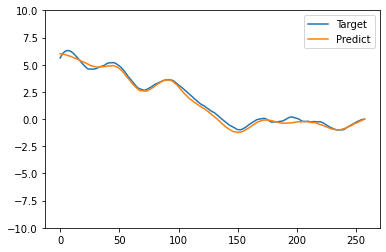

In [24]:
x = np.linspace(0, 257, 257)
for k in range(1):
    
    i = random.randint(0,len(rdfs))
    test = np.array([rdfs[i]])

    modelpred = model.predict([test])
    plt.plot(x, pots[i] - 30, label = 'Target')
    plt.plot(x, modelpred[0] - 30, label = 'Predict')
    
plt.legend()
plt.ylim(-10,10)

In [30]:
model.save('Model6')

INFO:tensorflow:Assets written to: Model6/assets


model1: loss ~ 1.5 \
        val_loss ~ 0.9
        
        
model2: ~0.17 \
        ~0.47
        
        
model3: ~0.17 \
        ~0.45
        
        
model4: loss: 0.1957 \
val_loss: 0.3878

model5: loss: 0.2075 \
val_loss: 0.3788

Model6: loss: 0.1921 - val_loss: 0.3682

In [4]:
test_inp = np.array(input_rdf.DFs[0].y)

In [5]:
input_pot = mt.ReadPot('NaNa.pot', quiet= True)
inpot = np.array(input_pot.DFs[0].y)
z = np.linspace(0, len(inpot), len(inpot))

In [6]:
test = np.array([test_inp])

modelpred = model.predict([test])

z = np.linspace(0, 15, 300)

pred = np.zeros(300)
act = np.zeros(300)
for i in range(1, 301):
    if i < len(modelpred[0]):
        pred[-i] = modelpred[0][-i]
    else:
        pred[-i] = 50000 + 3*i
        
        
    if i < len(inpot):
        act[-i] = inpot[-i]
    else:
        act[-i] = 50000 + 3*i
plt.plot(z, pred - 30, label = 'Predict')
plt.plot(z, act, label = 'True')
    
plt.legend()
plt.ylim(-10,10)

NameError: name 'model' is not defined

In [7]:
loadmodel = tf.keras.models.load_model('Model6', compile = False)
loadmodel.summary()
loadmodel.compile()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 257)               66306     
_________________________________________________________________
dense_14 (Dense)             (None, 80)                20640     
_________________________________________________________________
dense_15 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_16 (Dense)             (None, 257)               20817     
Total params: 114,243
Trainable params: 114,243
Non-trainable params: 0
_________________________________________________________________


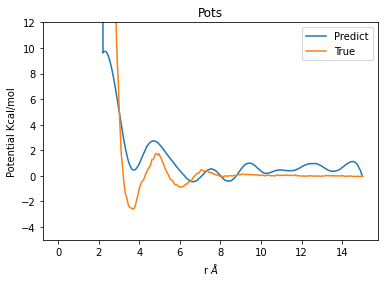

In [8]:
test = np.array([test_inp])

modelpred = loadmodel.predict([test])

z = np.linspace(0, 15, 300)

pred = np.zeros(300)
act = np.zeros(300)
for i in range(1, 301):
    if i < len(modelpred[0]):
        pred[-i] = modelpred[0][-i]
    else:
        pred[-i] = 50000 + 500*i
        
        
    if i < len(inpot):
        act[-i] = inpot[-i]
    else:
        act[-i] = 50000 + 50*i
plt.plot(z, pred - 30, label = 'Predict')
plt.plot(z, act, label = 'True')
    
plt.legend()
plt.ylim(-5,12)
plt.xlabel('r $\AA$')
plt.ylabel('Potential Kcal/mol')

plt.title('Pots')
plt.savefig('potentials.png')

In [18]:
N = len(input_rdf.AtomTypes)
N_NB = int(N*(N+1)/2) #number of non-bonded interactions
N_B = int(0) #number of bonded interactions
N_A = int(0) #number of angle interactions

AtomList = []
for i in range(len(input_rdf.AtomTypes)):
    AtomList.append(input_rdf.AtomTypes[i])
        
AtomPairs = list(it.combinations_with_replacement(AtomList, r = 2)) #all possible atoms pairs, no repeats
    
general_section = " &General \n" + " NTypes= {} \n".format(N) + " N_NB= {} \n".format(N_NB) + \
" N_B= {} \n".format(N_B) + " N_A= {} \n".format(N_A)+ " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + \
" NPoints= {} \n".format(NPoints) + " &EndGeneral \n"
    
potential_section = ''
for i in range(len(AtomPairs)):
    single_pot = pred
    header_section = " &Potential \n" + " Name= {}-{} \n".format(AtomPairs[i][0], AtomPairs[i][1]) + \
    " Type = NB \n" \
    + " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + " NPoints= {} \n".format(NPoints) + \
    " AtomTypes= {},{} \n".format(AtomPairs[i][0], AtomPairs[i][1])
        
    table_section = ' &Table \n'
    for j in range(len(rvalues)):
        rval = format(rvalues[j], '.7f')
        potval = format(single_pot[j], '.7f')
        table_section = table_section + "     " + str(rval) + "  " + str(potval) + " \n"
            
    table_section = table_section + " &EndTable \n" + " &EndPotential \n"
        
    potential_section = potential_section + header_section + table_section
        
potfile = open('Test/pred.pot', 'w')
potfile.write(general_section)
potfile.write(potential_section)
potfile.close()

In [20]:
pot = mt.ReadPot('Test/pred.pot', quiet = True)
mt.PotsExport(pot, MDEngine = 'LAMMPS', Rmaxtable = 15.5, PHImaxtable = 180.0, \
                npoints = 2500, Umax = 6000.0, \
                interpol = True, method = 'gauss', sigma = 0.5, noplot=True, hardcopy = False, \
                filename = 'Test/predpotential')

In [16]:
testrdf = mt.ReadRDF('Test/pred.rdf', quiet = True)
truerdf = mt.ReadRDF('Setup/NaNa.rdf', quiet = True)

In [25]:
x = rvalues
for i in range(2):
    if i == 0:
        obj = testrdf.DFs[0]
    if i == 1:
        obj = truerdf.DFs[0]
    N = 1
    for j in range(N):
        holder = np.empty((300))
        startindex = np.where(x == round(obj.x[0], 3))[0][0]
        for k in range(300):
            if k < startindex:
                holder[k] = 0
            elif k >= startindex and k-startindex < len(obj.x):
                holder[k] = obj.y[k-startindex]
            else:
                holder[k] = 0
        
    if i == 0:
        test = holder
        
    if i == 1:
        true = holder

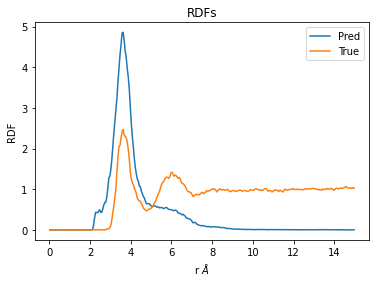

In [28]:
plt.plot(x, test, label = 'Pred')
plt.plot(x, true, label = 'True')

plt.legend()

plt.xlabel('r $\AA$')
plt.ylabel('RDF')
plt.title('RDFs')

plt.savefig('rdfs.png')

In [13]:
test = np.array([test_inp])

modelpred = loadmodel.predict([test])

loss_object = tf.keras.losses.MeanSquaredError()

print(loss_object(test[0], modelpred[0]))

tf.Tensor(924.05176, shape=(), dtype=float32)


In [16]:
print(len(test[0]), len(inpot))

257 244


In [14]:
print(test[0][0])
print(modelpred[0][0])

0.0037
39.417767


In [17]:
ytrue = np.zeros(244)
ypred = np.zeros(244)

for i in range(1, 245):
    ytrue[-i] = inpot[-i]
    ypred[-i] = test[0][-i]
    
print(loss_object(ytrue, ypred))

tf.Tensor(3.8450441360473633, shape=(), dtype=float64)
